https://www.codearmo.com/python-tutorial/merton-jump-diffusion-model-python

https://demonstrations.wolfram.com/OptionPricesInMertonsJumpDiffusionModel/


In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt
from scipy.stats import norm
from scipy.optimize import minimize_scalar 
from scipy.optimize import minimize

In [2]:
N = norm.cdf
Lookback_period=5                   #Only consider options traded in the past x days
Stock="AAPL"

In [3]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S

In [4]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

In [5]:
def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    

In [6]:
def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p 

In [7]:
def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p 

In [8]:
def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6), method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")

In [9]:
def optimal_params(x, mkt_prices, strikes):
    candidate_prices = merton_jump_call(S, strikes, T, r,
                                        sigma=x[0], m= x[1] ,
                                        v=x[2],lam= x[3])
    return np.linalg.norm(mkt_prices - candidate_prices, 2)

### Simulating Jump Diffusion

In [10]:
S = 100 # current stock price
T = 1 # time to maturity
r = 0.02 # risk free rate
m = 0 # mean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum
steps =10000 # time steps
Npaths = 5 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

Text(0.5, 1.0, 'Jump Diffusion Process')

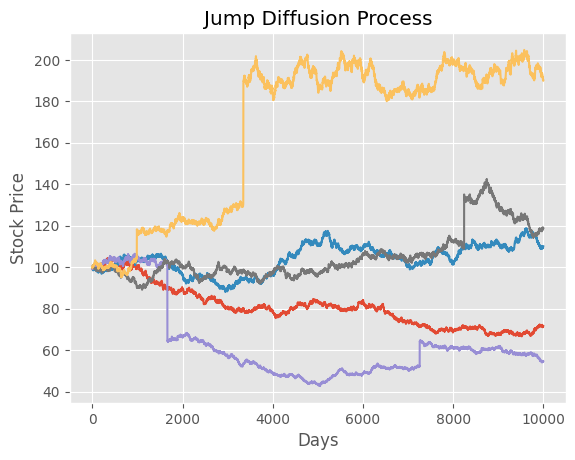

In [11]:
j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

### Closed Form Solution

In [12]:
S = 100 # current stock price
T = 1 # time to maturity
r = 0.02 # risk free rate
m = 0 # meean of jump size
v = 0.3 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
steps =255 # time steps
Npaths =200000 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process
K =100
np.random.seed(3)

In [13]:
j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths) #generate jump diffusion paths

mcprice = np.maximum(j[-1]-K,0).mean() * np.exp(-r*T) # calculate value of call

cf_price =  merton_jump_call(S, K, T, r, sigma, np.exp(m+v**2*0.5) , v, lam)

print('Merton Price =', cf_price)
print('Monte Carlo Merton Price =', mcprice)
print('Black Scholes Price =', BS_CALL(S,K,T,r, sigma))

Merton Price = 14.500570058304778
Monte Carlo Merton Price = 14.597509592911369
Black Scholes Price = 8.916037278572539


/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_70463/432580871.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  k_fact = np.math.factorial(k)


### Volatility Smile from Merton's Model

In [14]:
S = 100
strikes = np.arange(50,150,1)
r = 0.02
m = 1 
v = 0.3 
lam =1 
sigma = 0.2 
T= 1

In [15]:
mjd_prices = merton_jump_call(S, strikes, T, r, sigma, m, v, lam)
merton_ivs = [implied_vol(c, S, k, T, r) for c,k in zip(mjd_prices, strikes)]

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_70463/432580871.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  k_fact = np.math.factorial(k)


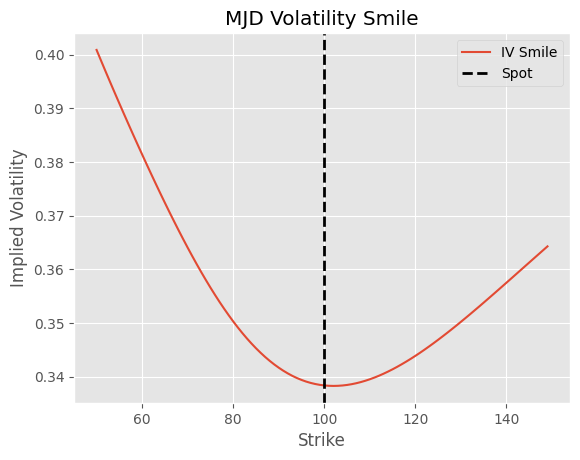

In [16]:
plt.plot(strikes, merton_ivs, label='IV Smile')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.axvline(S, color='black', linestyle='dashed', linewidth=2,label="Spot")
plt.title('MJD Volatility Smile')
plt.legend();

### Calculating the Volatility Smile

In [17]:
stock = yf.Ticker(Stock)
Underlying_Price = stock.info['currentPrice']
expirations = stock.options
expirations

('2024-08-23',
 '2024-08-30',
 '2024-09-06',
 '2024-09-13',
 '2024-09-20',
 '2024-09-27',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

In [18]:
today_date = dt.datetime.today()
expiration=dt.datetime.strptime(expirations[1], '%Y-%m-%d')
Time_to_expiration=(expiration-today_date).days
Time_to_expiration=Time_to_expiration/365.25

In [19]:
# This cell gets all the options expiring on a certain date for that ticker

option_chain = stock.option_chain(expirations[1])    #Second most immediate date
option_chain

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   AAPL240830C00100000 2024-07-25 15:10:43+00:00   100.0     118.50  125.30   
1   AAPL240830C00125000 2024-08-02 19:09:42+00:00   125.0      98.25  100.30   
2   AAPL240830C00135000 2024-08-13 17:46:24+00:00   135.0      86.65   90.35   
3   AAPL240830C00140000 2024-08-15 17:54:27+00:00   140.0      85.12   85.40   
4   AAPL240830C00145000 2024-08-16 17:54:20+00:00   145.0      81.42   80.35   
5   AAPL240830C00150000 2024-08-14 14:07:22+00:00   150.0      71.54   75.40   
6   AAPL240830C00160000 2024-08-16 13:32:33+00:00   160.0      64.35   65.45   
7   AAPL240830C00165000 2024-08-16 13:42:21+00:00   165.0      59.85   60.40   
8   AAPL240830C00170000 2024-08-16 16:05:08+00:00   170.0      56.45   55.50   
9   AAPL240830C00175000 2024-08-16 18:54:01+00:00   175.0      51.49   51.15   
10  AAPL240830C00180000 2024-08-16 19:14:57+00:00   180.0      46.59   45.55   
11  AAPL240830C00185000 20

In [20]:
# Get only calls

calls = option_chain.calls

In [21]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240830C00100000,2024-07-25 15:10:43+00:00,100.0,118.50,125.30,127.25,0.000000,0.000000,2.0,0,1.917969,True,REGULAR,USD
1,AAPL240830C00125000,2024-08-02 19:09:42+00:00,125.0,98.25,100.30,102.25,0.000000,0.000000,74.0,74,1.431643,True,REGULAR,USD
2,AAPL240830C00135000,2024-08-13 17:46:24+00:00,135.0,86.65,90.35,92.25,0.000000,0.000000,1.0,2,1.281254,True,REGULAR,USD
3,AAPL240830C00140000,2024-08-15 17:54:27+00:00,140.0,85.12,85.40,87.35,0.000000,0.000000,3.0,4,1.249027,True,REGULAR,USD
4,AAPL240830C00145000,2024-08-16 17:54:20+00:00,145.0,81.42,80.35,82.30,8.820000,12.148760,20.0,69,1.138676,True,REGULAR,USD
5,AAPL240830C00150000,2024-08-14 14:07:22+00:00,150.0,71.54,75.40,77.40,0.000000,0.000000,1.0,58,1.102544,True,REGULAR,USD
6,AAPL240830C00160000,2024-08-16 13:32:33+00:00,160.0,64.35,65.45,67.40,-0.940002,-1.439734,1.0,5,0.960938,True,REGULAR,USD
7,AAPL240830C00165000,2024-08-16 13:42:21+00:00,165.0,59.85,60.40,62.55,5.750000,10.628467,1.0,16,0.906251,True,REGULAR,USD
8,AAPL240830C00170000,2024-08-16 16:05:08+00:00,170.0,56.45,55.50,57.45,4.799999,9.293319,7.0,151,0.833009,True,REGULAR,USD
9,AAPL240830C00175000,2024-08-16 18:54:01+00:00,175.0,51.49,51.15,52.40,1.340000,2.671984,1.0,45,0.844240,True,REGULAR,USD


In [22]:
calls.reset_index(inplace=True)
calls['mid'] = (calls['bid'] + calls['ask'])/2
calls['Time'] = Time_to_expiration
calls['Underlying_Price'] = Underlying_Price

In [23]:
#We need a filter for last trade date, say no more than 5 days

calls["lastTradeDate"] = pd.to_datetime(calls["lastTradeDate"]).dt.tz_localize(None)
calls = calls[calls["lastTradeDate"] >= (dt.datetime.today() - dt.timedelta(days=Lookback_period))]

In [24]:
#We need a filter for open interest, say more than 0
calls = calls[calls["openInterest"] > 0]

In [25]:
calls

,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,mid,Time,Underlying_Price
2,2,AAPL240830C00135000,2024-08-13 17:46:24,135.0,86.65,90.35,92.25,0.000000,0.000000,1.0,2,1.281254,True,REGULAR,USD,91.300,0.030116,226.05
3,3,AAPL240830C00140000,2024-08-15 17:54:27,140.0,85.12,85.40,87.35,0.000000,0.000000,3.0,4,1.249027,True,REGULAR,USD,86.375,0.030116,226.05
4,4,AAPL240830C00145000,2024-08-16 17:54:20,145.0,81.42,80.35,82.30,8.820000,12.148760,20.0,69,1.138676,True,REGULAR,USD,81.325,0.030116,226.05
5,5,AAPL240830C00150000,2024-08-14 14:07:22,150.0,71.54,75.40,77.40,0.000000,0.000000,1.0,58,1.102544,True,REGULAR,USD,76.400,0.030116,226.05
6,6,AAPL240830C00160000,2024-08-16 13:32:33,160.0,64.35,65.45,67.40,-0.940002,-1.439734,1.0,5,0.960938,True,REGULAR,USD,66.425,0.030116,226.05
7,7,AAPL240830C00165000,2024-08-16 13:42:21,165.0,59.85,60.40,62.55,5.750000,10.628467,1.0,16,0.906251,True,REGULAR,USD,61.475,0.030116,226.05
8,8,AAPL240830C00170000,2024-08-16 16:05:08,170.0,56.45,55.50,57.45,4.799999,9.293319,7.0,151,0.833009,True,REGULAR,USD,56.475,0.030116,226.05
9,9,AAPL240830C00175000,2024-08-16 18:54:01,175.0,51.49,51.15,52.40,1.340000,2.671984,1.0,45,0.844240,True,REGULAR,USD,51.775,0.030116,226.05
10,10,AAPL240830C00180000,2024-08-16 19:14:57,180.0,46.59,45.55,47.50,4.889999,11.726617,10.0,197,0.704593,True,REGULAR,USD,46.525,0.030116,226.05
11,11,AAPL240830C00185000,2024-08-15 15:50:32,185.0,40.11,40.55,42.60,0.010002,0.024943,1.0,239,0.646488,True,REGULAR,USD,41.575,0.030116,226.05


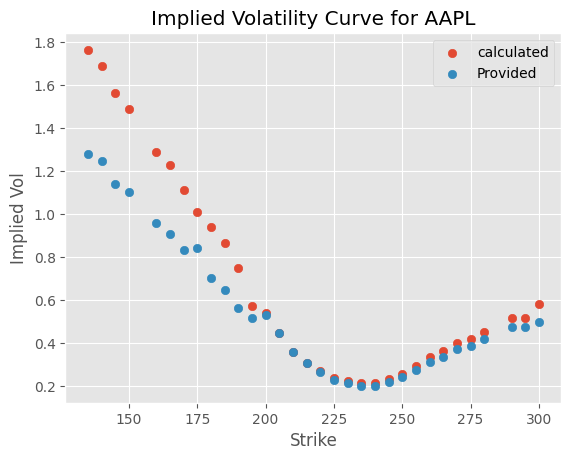

In [26]:
ivs = [] 

for row in calls.itertuples():
    iv = implied_vol(opt_value=row.ask, S=row.Underlying_Price, K=row.strike, T=row.Time, r=0.05)   #choose bid,ask,mid
    ivs.append(iv)

plt.scatter(calls.strike, ivs, label='calculated')
plt.scatter(calls.strike, calls.impliedVolatility, label='Provided')
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title(f'Implied Volatility Curve for {Stock}')
plt.legend() 

### Model Calibration to Market Prices

In [27]:
# This cell gets all the available expirations for a ticker

stock = yf.Ticker(Stock)
Underlying_Price = stock.info['currentPrice']
expirations = stock.options
expirations

('2024-08-23',
 '2024-08-30',
 '2024-09-06',
 '2024-09-13',
 '2024-09-20',
 '2024-09-27',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

In [28]:
# This cell gets all the options expiring on a certain date for that ticker

option_chain = stock.option_chain(expirations[1])    #Second most immediate date
option_chain

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   AAPL240830C00100000 2024-07-25 15:10:43+00:00   100.0     118.50  125.30   
1   AAPL240830C00125000 2024-08-02 19:09:42+00:00   125.0      98.25  100.30   
2   AAPL240830C00135000 2024-08-13 17:46:24+00:00   135.0      86.65   90.35   
3   AAPL240830C00140000 2024-08-15 17:54:27+00:00   140.0      85.12   85.40   
4   AAPL240830C00145000 2024-08-16 17:54:20+00:00   145.0      81.42   80.35   
5   AAPL240830C00150000 2024-08-14 14:07:22+00:00   150.0      71.54   75.40   
6   AAPL240830C00160000 2024-08-16 13:32:33+00:00   160.0      64.35   65.45   
7   AAPL240830C00165000 2024-08-16 13:42:21+00:00   165.0      59.85   60.40   
8   AAPL240830C00170000 2024-08-16 16:05:08+00:00   170.0      56.45   55.50   
9   AAPL240830C00175000 2024-08-16 18:54:01+00:00   175.0      51.49   51.15   
10  AAPL240830C00180000 2024-08-16 19:14:57+00:00   180.0      46.59   45.55   
11  AAPL240830C00185000 20

In [29]:
today_date = dt.datetime.today()
expiration=dt.datetime.strptime(expirations[1], '%Y-%m-%d')
Time_to_expiration=(expiration-today_date).days
Time_to_expiration=Time_to_expiration/365.25

In [30]:
Time_to_expiration

0.030116358658453114

In [31]:
# Get only calls

calls = option_chain.calls

In [32]:
calls.reset_index(inplace=True)
calls['mid'] = (calls['bid'] + calls['ask'])/2
calls['Time'] = Time_to_expiration
calls['Underlying_Price'] = Underlying_Price

In [33]:
#We need a filter for last trade date, say no more than 5 days

calls["lastTradeDate"] = pd.to_datetime(calls["lastTradeDate"]).dt.tz_localize(None)
calls = calls[calls["lastTradeDate"] >= (dt.datetime.today() - dt.timedelta(days=Lookback_period))]

In [34]:
#We need a filter for open interest, say more than 0
calls = calls[calls["openInterest"] > 0]

In [35]:
calls

,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,mid,Time,Underlying_Price
2,2,AAPL240830C00135000,2024-08-13 17:46:24,135.0,86.65,90.35,92.25,0.000000,0.000000,1.0,2,1.281254,True,REGULAR,USD,91.300,0.030116,226.05
3,3,AAPL240830C00140000,2024-08-15 17:54:27,140.0,85.12,85.40,87.35,0.000000,0.000000,3.0,4,1.249027,True,REGULAR,USD,86.375,0.030116,226.05
4,4,AAPL240830C00145000,2024-08-16 17:54:20,145.0,81.42,80.35,82.30,8.820000,12.148760,20.0,69,1.138676,True,REGULAR,USD,81.325,0.030116,226.05
5,5,AAPL240830C00150000,2024-08-14 14:07:22,150.0,71.54,75.40,77.40,0.000000,0.000000,1.0,58,1.102544,True,REGULAR,USD,76.400,0.030116,226.05
6,6,AAPL240830C00160000,2024-08-16 13:32:33,160.0,64.35,65.45,67.40,-0.940002,-1.439734,1.0,5,0.960938,True,REGULAR,USD,66.425,0.030116,226.05
7,7,AAPL240830C00165000,2024-08-16 13:42:21,165.0,59.85,60.40,62.55,5.750000,10.628467,1.0,16,0.906251,True,REGULAR,USD,61.475,0.030116,226.05
8,8,AAPL240830C00170000,2024-08-16 16:05:08,170.0,56.45,55.50,57.45,4.799999,9.293319,7.0,151,0.833009,True,REGULAR,USD,56.475,0.030116,226.05
9,9,AAPL240830C00175000,2024-08-16 18:54:01,175.0,51.49,51.15,52.40,1.340000,2.671984,1.0,45,0.844240,True,REGULAR,USD,51.775,0.030116,226.05
10,10,AAPL240830C00180000,2024-08-16 19:14:57,180.0,46.59,45.55,47.50,4.889999,11.726617,10.0,197,0.704593,True,REGULAR,USD,46.525,0.030116,226.05
11,11,AAPL240830C00185000,2024-08-15 15:50:32,185.0,40.11,40.55,42.60,0.010002,0.024943,1.0,239,0.646488,True,REGULAR,USD,41.575,0.030116,226.05


In [36]:
T = Time_to_expiration
S = Underlying_Price
r = 0 
x0 = [0.15, 1, 0.1, 1]                                         # initial guess for algorithm
bounds = ((0.01, np.inf) , (0.01, 2), (1e-5, np.inf) , (0, 5)) # bounds as described above
strikes = calls.strike.values
prices = calls.ask.values                                      # Can choose bid, ask, mid

In [37]:
res = minimize(optimal_params, method='SLSQP',  x0=x0, args=(prices, strikes),
                  bounds = bounds, tol=1e-20, 
                  options={"maxiter":1000})
sigt = res.x[0]
mt = res.x[1]
vt = res.x[2]
lamt = res.x[3]

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_70463/432580871.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  k_fact = np.math.factorial(k)
/Users/benny/Desktop/Projects/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [38]:
print('Calibrated Volatlity = ', sigt)
print('Calibrated Jump Mean = ', mt)
print('Calibrated Jump Std = ', vt)
print('Calibrated intensity = ', lamt)

Calibrated Volatlity =  0.18768631479191245
Calibrated Jump Mean =  0.01
Calibrated Jump Std =  0.7066875294987974
Calibrated intensity =  0.23933437640628744


/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_70463/432580871.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  k_fact = np.math.factorial(k)


Text(0.5, 1.0, 'Merton Model Optimal Params')

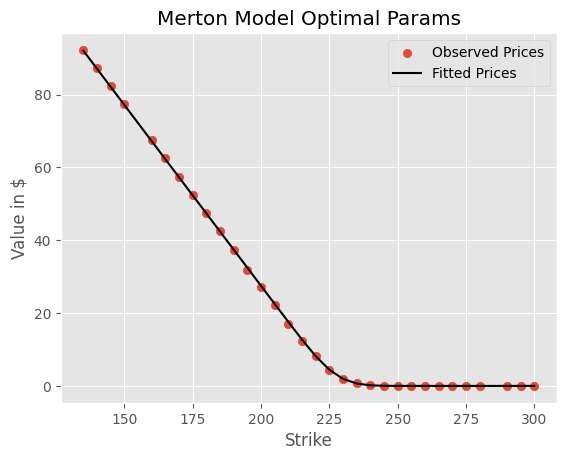

In [39]:
calls['least_sq_V'] = merton_jump_call(S= Underlying_Price, K=calls.strike, T = Time_to_expiration, r=0 ,sigma=sigt, m=mt, v=vt, lam=lamt)

plt.scatter(calls.strike, calls.ask,label= 'Observed Prices')
plt.plot(calls.strike, calls.least_sq_V, color='black',label= 'Fitted Prices')
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Value in $')
plt.title('Merton Model Optimal Params')